In [5]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import functools
from rich.progress import BarColumn, Progress, TextColumn, TimeRemainingColumn

from nerfstudio.engine.optimizers import Optimizers
from nerfstudio.engine.optimizers import AdamOptimizerConfig
from nerfstudio.engine.schedulers import ExponentialDecaySchedulerConfig

from reni.configs.reni_config import RENIField
from reni.utils.utils import find_nerfstudio_project_root
from reni.utils.colourspace import linear_to_sRGB

project_root = find_nerfstudio_project_root(Path(os.getcwd()))
# set current working directory to nerfstudio project root
os.chdir(project_root)

# setup config
test_mode = 'val'
world_size = 1
local_rank = 0
device = 'cuda:0'

reni_config = RENIField
reni_config.config.load_dir = Path(f'/workspace/outputs/reni/reni_plus_plus_models/latent_dim_100/nerfstudio_models/')
reni_config.config.load_step = 50000
reni_config.config.pipeline.datamanager.dataparser.custom_val_folder = Path('/workspace/data/custom_data_folder') # Set to custom data folder of .exr environment maps
reni_config.config.pipeline.datamanager.dataparser.eval_mask_path = Path('/workspace/data/RENI_HDR/masks/01.png') # Set to desired mask folder
reni_config.config.pipeline.model_load_strict = False # As custom val folder is used, set to False
reni_config.config.vis = "tensorboard"

trainer = reni_config.config.setup(local_rank=local_rank, world_size=world_size)
trainer.setup(test_mode=test_mode)
pipeline = trainer.pipeline
datamanager = pipeline.datamanager
model = pipeline.model
model.eval()
model.fitting_eval_latents = True # To use eval loss functions

[15:12:00] Saving checkpoints to: outputs/reni/reni/{timestamp}/nerfstudio_models                         ]8;id=262549;file:///workspace/nerfstudio/engine/trainer.py\trainer.py]8;;\:]8;id=589278;file:///workspace/nerfstudio/engine/trainer.py#134\134]8;;\

Setting up training dataset...

Caching all 3346 images.

Warning: If you run out of memory, try reducing the number of images to sample from.

Output()

Setting up evaluation dataset...

Caching all 10 images.

Output()

Done loading Nerfstudio checkpoint from 
/workspace/outputs/reni/reni_plus_plus_models/latent_dim_100/nerfstudio_models/step-000050000.ckpt

logging events to: outputs/reni/reni/{timestamp}

In [6]:
# create latent codes to fit
latent_codes = torch.nn.Parameter(torch.zeros((len(datamanager.eval_dataset), model.field.latent_dim, 3), requires_grad=True, device=device))
scale = torch.nn.Parameter(torch.ones((len(datamanager.eval_dataset)), requires_grad=True, device=device))

# setup optimiser
optimiser_config = {
    "eval_latents": {
        "optimizer": AdamOptimizerConfig(lr=1e-1, eps=1e-15),
        "scheduler": ExponentialDecaySchedulerConfig(lr_final=1e-7, max_steps=2500),
    },
}
param_group = {"latents": [latent_codes, scale]}
optimizer = Optimizers(optimiser_config, param_group)
steps = optimizer.config["eval_latents"]["scheduler"].max_steps

with Progress(
    TextColumn("[progress.description]{task.description}"),
    BarColumn(),
    TextColumn("[progress.percentage]{task.percentage:>3.0f}%"),
    TimeRemainingColumn(),
    TextColumn("[blue]Loss: {task.fields[loss]}"),
    TextColumn("[green]LR: {task.fields[lr]}"),
) as progress:
    task = progress.add_task("[green]Fitting latents... ", total=steps, loss="", lr="")

    for step in range(steps):
        # Sample a batch of rays within the unmasked region
        if model.config.eval_latent_batch_type == 'ray_samples':
            ray_bundle, batch = datamanager.next_eval(step)
        else:
            _, ray_bundle, batch = datamanager.next_eval_image(step)
        
        # Sample the corresponding latent codes and scale for each ray image index
        latent_code_sample = latent_codes[ray_bundle.camera_indices.squeeze()] # [num_rays, latent_dim, 3]
        scale_sample = scale[ray_bundle.camera_indices.squeeze()] # [num_rays]

        # Get model output
        model_outputs = model.get_outputs(ray_bundle, rotation=None, latent_codes=latent_code_sample, scale=scale_sample)
        if model.metadata["fit_val_in_ldr"]:
            model_outputs["rgb"] = linear_to_sRGB(model.field.unnormalise(model_outputs["rgb"]))
        loss_dict = model.get_loss_dict(model_outputs, batch, ray_bundle)
        # add losses together
        loss = functools.reduce(torch.add, loss_dict.values())
        optimizer.zero_grad_all()
        loss.backward()
        optimizer.optimizer_step("latents")
        optimizer.scheduler_step("latents")

        progress.update(
            task,
            advance=1,
            loss=f"{loss.item():.4f}",
            lr=f"{optimizer.schedulers['latents'].get_last_lr()[0]:.8f}",
        )

Output()

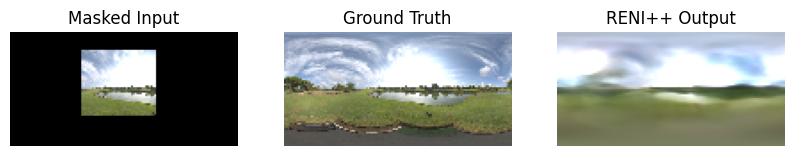

In [26]:
# Ground truth image
H, W = datamanager.eval_dataset.metadata['image_height'], datamanager.eval_dataset.metadata['image_width']
idx, ray_bundle, batch = datamanager.next_eval_image(2)
img = batch['image'].reshape(H, W, 3)
img_ldr = linear_to_sRGB(model.field.unnormalise(img))
masked_ldr = img_ldr * batch['mask'].reshape(H, W, 1)

# RENI++ outpainting
latent_code_sample = latent_codes[ray_bundle.camera_indices.squeeze()] # [num_rays, latent_dim, 3]
scale_sample = scale[ray_bundle.camera_indices.squeeze()] # [num_rays]
model_outputs = model.get_outputs(ray_bundle, rotation=None, latent_codes=latent_code_sample, scale=scale_sample)
rgb = model_outputs["rgb"].reshape(H, W, 3)
rgb_ldr = linear_to_sRGB(model.field.unnormalise(rgb))
rgb_ldr = rgb_ldr.cpu().detach().numpy()

# plot masked image, img_ldr and model output
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(masked_ldr)
ax[0].set_title('Masked Input')
ax[1].imshow(img_ldr)
ax[1].set_title('Ground Truth')
ax[2].imshow(rgb_ldr)
ax[2].set_title('RENI++ Output')
for a in ax:
    a.axis('off')
plt.show()